#### Some of the code in this notebook will be from our exploration code, the processing step will be very similar to the Data Science Bowl 2017 preprocessing youtube video I shared.

In [29]:
import pandas as pd
import pydicom
import os
import matplotlib.pyplot as plt
import numpy as np
import cv2
from tqdm import tqdm # this is going to help us track the progrerss of processing

#### We need to resize our data and prepare it for a nural network to do this lets frist create a dataframe that contains a row with number of slices, and the size of of the images

#### Note: I went through this dataset a whileback and found that there were issues with the following patients' dicom files:
##### 'ID00011637202177653955184', 'ID00026637202179561894768',  'ID00128637202219474716089', 'ID00132637202222178761324'

In [30]:
data_dir = 'F:/OISC/osic-pulmonary-fibrosis-progression/train/'
patients = os.listdir(data_dir)

In [31]:
#create a dataframe that we will append data to
df = pd.DataFrame(columns = ['patient','num_slices', 'size'])
df
#accroding to this post: https://stackoverflow.com/questions/10715965/add-one-row-to-pandas-dataframe
#the fastest way to append data is by using a dict
#speed is important at scale, this is a relativley small data set so it's not too important

,patient,num_slices,size


In [33]:
#test on 10 patients to see if it works
for patient in tqdm(patients[:10]):
    try:
        path = data_dir + patient 
        slices = [pydicom.read_file(path + '/' + s) for s in os.listdir(path)] 
        slices.sort(key = lambda x: float(x.ImagePositionPatient[2]))
        df_dict = {'patient' : patient, 'num_slices': len(slices), 'size': slices[0].pixel_array.shape}
        df = df.append(df_dict, ignore_index = True)
    except:
        pass
    
#I am using try and excpet becuase some of our images cause issues, so if we come across them, they will just get skipepd

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:04<00:00,  2.12it/s]


In [34]:
df

,patient,num_slices,size
0,ID00007637202177411956430,30,"(512, 512)"
1,ID00009637202177434476278,394,"(768, 768)"
2,ID00010637202177584971671,106,"(512, 512)"
3,ID00007637202177411956430,30,"(512, 512)"
4,ID00009637202177434476278,394,"(768, 768)"
5,ID00010637202177584971671,106,"(512, 512)"
6,ID00012637202177665765362,49,"(512, 512)"
7,ID00014637202177757139317,31,"(843, 888)"
8,ID00015637202177877247924,295,"(768, 768)"
9,ID00019637202178323708467,29,"(512, 512)"


In [35]:
#get info for all patients, dont forget to recreate the dataframe
df = pd.DataFrame(columns = ['patient','num_slices', 'size'])
for patient in tqdm(patients):
    try:
        path = data_dir + patient 
        slices = [pydicom.read_file(path + '/' + s) for s in os.listdir(path)] 
        slices.sort(key = lambda x: float(x.ImagePositionPatient[2]))
        df_dict = {'patient' : patient, 'num_slices': len(slices), 'size': slices[0].pixel_array.shape}
        df = df.append(df_dict, ignore_index = True)
    except:
        pass
    
#gonna go eat a mango or something while this processes

100%|████████████████████████████████████████████████████████████████████████████████| 176/176 [03:05<00:00,  1.06s/it]


#### The time to process will vary based on your computer, for this process we are limited to the single core speed of our processor as python is single threaded. Later we will explore multiprocessing and how greatly it improves our processing.
#### For reference I am running a i7-4790k, I can see its clocked at its max 4.2 ghz speed during this processing. Other factors to consider will be disk transfor rate. More on that later.

In [36]:
df.head()

,patient,num_slices,size
0,ID00007637202177411956430,30,"(512, 512)"
1,ID00009637202177434476278,394,"(768, 768)"
2,ID00010637202177584971671,106,"(512, 512)"
3,ID00012637202177665765362,49,"(512, 512)"
4,ID00014637202177757139317,31,"(843, 888)"


In [37]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 172 entries, 0 to 171
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   patient     172 non-null    object
 1   num_slices  172 non-null    object
 2   size        172 non-null    object
dtypes: object(3)
memory usage: 4.2+ KB


In [38]:
#lets do some quick frequncy distribution
print(df['num_slices'].describe())
print(df['size'].describe()) # now that i think of it, size doesn't really matter beacuse we will be resizing to something
#like 50x50 or 100x100

count     172
unique    118
top        30
freq        9
Name: num_slices, dtype: int64
count            172
unique            10
top       (512, 512)
freq             131
Name: size, dtype: object


In [39]:
# lets figure out a way to bin and plot our num_slices column
print('Min: ' + str(df['num_slices'].min()))
print('Max: ' + str(df['num_slices'].max())) # this doesnt seem right, that is a crazy amount of slices)
print('Mean ' + str(df['num_slices'].mean()))
print('Median: ' + str(df['num_slices'].median()))
#whats the point of learning R when you can do all this in python... JK


Min: 12
Max: 1018
Mean 187.79651162790697
Median: 98.0


(array([90., 10., 32., 21., 13.,  4.,  0.,  0.,  1.,  1.]),
 array([12.0, 112.6, 213.2, 313.79999999999995, 414.4, 515.0,
        615.5999999999999, 716.1999999999999, 816.8, 917.4, 1018.0],
       dtype=object),
 <BarContainer object of 10 artists>)

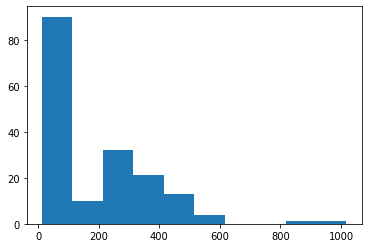

In [40]:
plt.hist(df['num_slices'])
# check this out for the defaul binning https://matplotlib.org/3.3.1/api/_as_gen/matplotlib.pyplot.hist.html

(array([94.,  9., 37., 17., 10.,  3.,  0.,  1.,  1.]),
 array([12.0, 123.77777777777777, 235.55555555555554, 347.3333333333333,
        459.1111111111111, 570.8888888888889, 682.6666666666666,
        794.4444444444443, 906.2222222222222, 1018.0], dtype=object),
 <BarContainer object of 9 artists>)

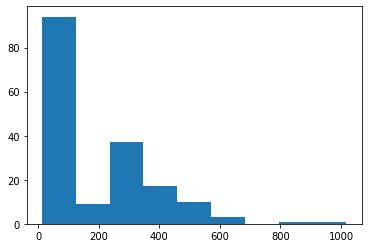

In [41]:
#lets figure out a way to bin using sturges method... https://numpy.org/devdocs/reference/generated/numpy.histogram_bin_edges.html

import numpy as np
bins = np.histogram_bin_edges(df['num_slices'], bins = 'sturges')



plt.hist(df['num_slices'], bins =bins)

In [42]:
#I am going to stick with the first method, probably going to omit the ones with greater than 600 slices

df[df['num_slices'] <50] # going to check out directory and make sure i didnt make a mistake with the processing
#yep there are definatly that amount of files in there



,patient,num_slices,size
0,ID00007637202177411956430,30,"(512, 512)"
3,ID00012637202177665765362,49,"(512, 512)"
4,ID00014637202177757139317,31,"(843, 888)"
6,ID00019637202178323708467,29,"(512, 512)"
8,ID00023637202179104603099,27,"(512, 512)"
9,ID00025637202179541264076,24,"(768, 768)"
17,ID00048637202185016727717,26,"(512, 512)"
22,ID00062637202188654068490,30,"(512, 512)"
25,ID00072637202198161894406,24,"(512, 512)"
32,ID00086637202203494931510,30,"(788, 888)"


<AxesSubplot:>

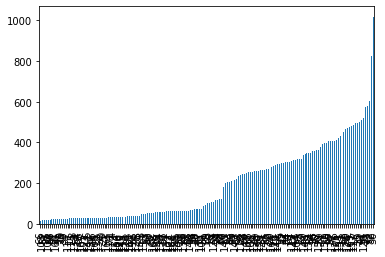

In [43]:
df.num_slices.sort_values().plot.bar() # plot to get a general idea of where everything lands

#### Below we will find the slope of FVC for each patient, and then append a 0 or 1 as a label. 0 being no decrease in FVC and 1 meaning their FVC did decrease.

In [44]:
import pandas as pd
import numpy as np
df_train = pd.read_csv('F:/OISC/osic-pulmonary-fibrosis-progression/train.csv')


In [45]:
df_train.head()

,Patient,Weeks,FVC,Percent,Age,Sex,SmokingStatus
0,ID00007637202177411956430,-4,2315,58.253649,79,Male,Ex-smoker
1,ID00007637202177411956430,5,2214,55.712129,79,Male,Ex-smoker
2,ID00007637202177411956430,7,2061,51.862104,79,Male,Ex-smoker
3,ID00007637202177411956430,9,2144,53.950679,79,Male,Ex-smoker
4,ID00007637202177411956430,11,2069,52.063412,79,Male,Ex-smoker


In [46]:
#slope for first patient
patient = df_train['Patient'][0]

#basically y=mx+b and m is our slope, we will use numpy to calculate the slope
x = df_train[df_train["Patient"]==patient]["Weeks"]
y = df_train[df_train["Patient"]==patient]["FVC"]
print(x)
print(y)
slope = np.polyfit(x, y, 1)[0]
print(slope )
#appends the slope to the sata frame in a new column
df_train.loc[df_train["Patient"]==patient, 'Slope'] = slope 

0    -4
1     5
2     7
3     9
4    11
5    17
6    29
7    41
8    57
Name: Weeks, dtype: int64
0    2315
1    2214
2    2061
3    2144
4    2069
5    2101
6    2000
7    2064
8    2057
Name: FVC, dtype: int64


LinAlgError: SVD did not converge in Linear Least Squares

In [47]:
#gotta be better way/ proper way in pandas than with loop
#get slope of all patients
for patient in patients:
    x = df_train[df_train["Patient"]==patient]["Weeks"] 
    y = df_train[df_train["Patient"]==patient]["FVC"]
    slope = np.polyfit(x, y, 1)[0]
    df_train.loc[df_train["Patient"]==patient, 'Slope'] = slope

In [48]:
#deleate columns that are no longer needed
del df_train['Weeks']
del df_train['FVC']
del df_train["Percent"]

In [49]:
#because we deleted those columns, we have alot of duplicate rows, this will remove them
df_train = df_train.drop_duplicates()

In [51]:
#determine what is considered decreasing FVC
df_train.head()

,Patient,Age,Sex,SmokingStatus,Slope
0,ID00007637202177411956430,79,Male,Ex-smoker,-3.167126
9,ID00009637202177434476278,69,Male,Ex-smoker,-9.379955
18,ID00010637202177584971671,60,Male,Ex-smoker,-17.042803
27,ID00011637202177653955184,72,Male,Ex-smoker,-4.548925
36,ID00012637202177665765362,65,Male,Never smoked,-8.543079


<AxesSubplot:>

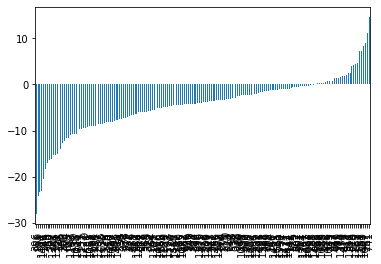

In [53]:
#lets just plot this and bin
df_train.Slope.sort_values().plot.bar()

### ooo pretty
## those with the high FVC score increase, I wonder if they stopped smoking or something

In [54]:
print(df_train.Slope.median())
print(df_train.Slope.mean())
# I am going to choose -3% as the split point

#greater than -3% means no decrease in FVC = 0
#less than -3% means decrease = 1

-3.9091097159817165
-4.5243014424362915


In [55]:
df_train[df_train['Slope'] > -3]

,Patient,Age,Sex,SmokingStatus,Slope
80,ID00023637202179104603099,71,Female,Ex-smoker,-2.549152
98,ID00026637202179561894768,57,Male,Ex-smoker,-2.967859
142,ID00038637202182690843176,71,Male,Ex-smoker,-0.800797
151,ID00042637202184406822975,58,Male,Ex-smoker,0.598134
166,ID00048637202185016727717,70,Female,Never smoked,-1.190408
...,...,...,...,...,...
1477,ID00411637202309374271828,65,Male,Ex-smoker,-0.956803
1495,ID00417637202310901214011,66,Male,Never smoked,-1.161601
1504,ID00419637202311204720264,73,Male,Ex-smoker,-2.135975
1513,ID00421637202311550012437,68,Male,Ex-smoker,-1.554030


In [56]:
#thanks to https://stackoverflow.com/questions/50375985/pandas-add-column-with-value-based-on-condition-based-on-other-columns
#google everything lol

df_train['label'] = 0
df_train.loc[df_train['Slope'] < -3,'label'] = 1
df_train.head()

#gonna just ignore those NaN values for now

,Patient,Age,Sex,SmokingStatus,Slope,label
0,ID00007637202177411956430,79,Male,Ex-smoker,-3.167126,1
9,ID00009637202177434476278,69,Male,Ex-smoker,-9.379955,1
18,ID00010637202177584971671,60,Male,Ex-smoker,-17.042803,1
27,ID00011637202177653955184,72,Male,Ex-smoker,-4.548925,1
36,ID00012637202177665765362,65,Male,Never smoked,-8.543079,1


In [57]:
df_train[df_train['Patient'] == patient]['label']

1540    0
Name: label, dtype: int64

### Below, we will create the process of configuring the data for the nural network.
#### Per our meeting on Oct 10, we will initially focus on preparing the dicom images for a nural network of some sort. Initially we will just throw all the images at the nural network rather than associate them with a patient. Additionally we will use binary classification to simplify things 0 will mean that that image did not see a decrease in FVC, 1 will mean the FVC did decrease.
#### Here is a breakdown of what we will want to do to get our data in a format for a nural network.


<ol>
<li>Sort the Slices</li>
<li>Get the size of all the slices (I previously found the minimum to be 512 x 512)</li>
<li>Resize the slices to the minimum size (This turns out to be step 4)</li>
<li>Normalize the slices so they are within the HU range (This turns out to be step 3)</li>
<li>Append the new slices to a list with its label [slice, label]</li>
<li>Save this new list as a numpy array</li>
<li>Use the train nural network - seen in another notebook</li>
</ol>

#### First, lets get familiar with pixel data arrays







In [48]:
#each dicom image has what is called a pixel array, this is what we plotted in the exploration notbook
#a pixel array is basically what the computer uses to create an image that we see on our screens and with our eyes
#a nural network just looks at the pixel array, most image processing is not really image based, but numerical
#all images have pixels and those pixels have numerical values associated with them

import pydicom
import pandas as pd
import os
from tqdm import tqdm

data_dir = 'F:/OISC/osic-pulmonary-fibrosis-progression/train/'
patients = os.listdir(data_dir)

#lets use our 5th patient as an example, this will help me explain how the pixel array works

p = patients[4]


#sort the slices and get the first slice of the dicom images
path = data_dir + p 
slices = [pydicom.read_file(path + '/' + s) for s in os.listdir(path)] 
slices.sort(key = lambda x: float(x.ImagePositionPatient[2])) #step 1

s = slices[0]

In [49]:
s
#as we can see below, we have 843 rows and 888 columns

Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 200
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: CT Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 2.25.146384665664824615103282803643723619214
(0002, 0010) Transfer Syntax UID                 UI: Explicit VR Little Endian
(0002, 0012) Implementation Class UID            UI: 1.2.276.0.7230010.3.0.3.6.1
(0002, 0013) Implementation Version Name         SH: 'OSIRIX_361'
(0002, 0016) Source Application Entity Title     AE: 'ANONYMOUS'
-------------------------------------------------
(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0008) Image Type                          CS: ['ORIGINAL', 'PRIMARY', 'AXIAL']
(0008, 0018) SOP Instance UID                    UI: 2.25.146384665664824615103282803643723619214
(0008, 0060) Modality                            CS: 'CT'
(0008, 0070

In [50]:
#a pixel array is really just an array of arrays or list of lists
s.pixel_array

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int16)

In [51]:
#if we print the len of pixel array we notice it is the same as the numbers of rows
print(f'Len of Pixel Array: {len(s.pixel_array)}')

Len of Pixel Array: 843


In [52]:
#if we prent the len of the first element in the pixel array we notice it is the same as the number of columns
len(s.pixel_array[0])

888

In [53]:
#so the way we can interperate this is that each item in the pixel array represents a row, and each item in
#the row repesents the intensity of the pixel each column for that row

#Example assume we have a pixel array of 3x4 (3 rows by 4 columns), our array would look like this:
array_of_arrays = [[0,1,3,9], [9,0,7,3], [4,7,2,0]]

In [54]:
#rows
len(array_of_arrays)

3

In [55]:
#columns
len(array_of_arrays[0])

4

In [ ]:
#how this looks in a grid, imagine each number represents the greyscale intensisty, 0 being black and 9 being white
0 1 3 9
9 0 7 3
4 7 2 0

#our dicom images work similarly, but obviously have much more rows and columns

c:\users\tom\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:2: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  


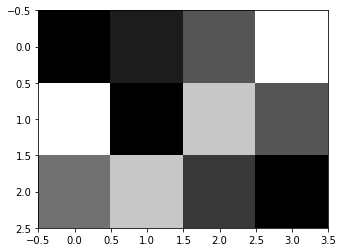

In [57]:
#wonder what happpens if I try to graph this
plt.imshow(array_of_arrays, CMAP ='gray')
plt.show()

#crazy i actually just made up that 0 is black and white is 9 as an example, but i guess that's how it really works lol
#hopefully this makes it more clear of how the pixel array works

In [110]:
#moving on to step 2, again lets only work with one patient for now
#I am using a libray called open-cv2 to resize 10/10 would recomend

#pip install opencv-python   
#-or-
#conda install -c conda-forge opencv


#the normalize to HU code I got from here:
# https://www.kaggle.com/allunia/pulmonary-dicom-preprocessing

# we need to do this becasue the range of our pixel intesities is not similar accross all patients, I think this is 
# because not all machines are the same and not all patients were scanned on the same machine.

#normalizig to the HU range will fix all of this, it will also be useful if we later decide to attempt to remove scans
#that are clearly not lungs



#######################################################################################

#code from https://www.kaggle.com/allunia/pulmonary-dicom-preprocessing

def set_outside_scanner_to_air(raw_pixelarrays):
    # in OSIC we find outside-scanner-regions with raw-values of -2000. 
    # Let's threshold between air (0) and this default (-2000) using -1000
    raw_pixelarrays[raw_pixelarrays <= -1000] = 0
    return raw_pixelarrays

def transform_to_hu(slices):
    images = np.stack([file.pixel_array for file in slices])
    images = images.astype(np.int16)

    images = set_outside_scanner_to_air(images)
    
    # convert to HU
    for n in range(len(slices)):
        
        intercept = slices[n].RescaleIntercept
        slope = slices[n].RescaleSlope
        
        if slope != 1:
            images[n] = slope * images[n].astype(np.float64)
            images[n] = images[n].astype(np.int16)
            
        images[n] += np.int16(intercept)
    
    return np.array(images, dtype=np.int16)

#######################################################################################

#change of plans transform to HU is now step

much_data = []

import cv2

new_size = 512 #step 2

path = data_dir + p 
slices = [pydicom.read_file(path + '/' + s) for s in os.listdir(path)] 
slices.sort(key = lambda x: float(x.ImagePositionPatient[2])) #step 1
slices = transform_to_hu(slices)#step 3
slices = [cv2.resize(np.array(each_slice), (new_size, new_size)) for each_slice in slices] #step 4
label = int(df_train[df_train['Patient'] == p]['label'])#step 5 get the label value
for each_slice in slices: 
    much_data.append([each_slice, label]) #step 5


np.save('data.npy', much_data) #step 6

#we can later load this data by doing the below

#much_data = np.load('data.npy', allow_pickle = True)


#### Below we will everything together and turn it into a little program

In [2]:
import pandas as pd
import pydicom
import numpy as np
import os
import cv2
from tqdm import tqdm


NEW_SIZE = 512

DATA_DIR = 'F:/OISC/osic-pulmonary-fibrosis-progression/train/'
PATIENTS = os.listdir(DATA_DIR)

df_train = pd.read_csv('F:/OISC/osic-pulmonary-fibrosis-progression/train.csv')



#slope
for patient in PATIENTS:
    x = df_train[df_train["Patient"]==patient]["Weeks"] 
    y = df_train[df_train["Patient"]==patient]["FVC"]
    slope = np.polyfit(x, y, 1)[0]
    df_train.loc[df_train["Patient"]==patient, 'Slope'] = slope
del df_train['Weeks']
del df_train['FVC']
del df_train["Percent"]
df_train = df_train.drop_duplicates()
df_train['label'] = 0
df_train.loc[df_train['Slope'] < -3,'label'] = 1

#######################################################################################

#code from https://www.kaggle.com/allunia/pulmonary-dicom-preprocessing

def set_outside_scanner_to_air(raw_pixelarrays):
    # in OSIC we find outside-scanner-regions with raw-values of -2000. 
    # Let's threshold between air (0) and this default (-2000) using -1000
    raw_pixelarrays[raw_pixelarrays <= -1000] = 0
    return raw_pixelarrays

def transform_to_hu(slices):
    images = np.stack([file.pixel_array for file in slices])
    images = images.astype(np.int16)

    images = set_outside_scanner_to_air(images)
    
    # convert to HU
    for n in range(len(slices)):
        
        intercept = slices[n].RescaleIntercept
        slope = slices[n].RescaleSlope
        
        if slope != 1:
            images[n] = slope * images[n].astype(np.float64)
            images[n] = images[n].astype(np.int16)
            
        images[n] += np.int16(intercept)
    
    return np.array(images, dtype=np.int16)

#######################################################################################

#program
def process_data(data_dir = DATA_DIR, patients = PATIENTS, new_size = NEW_SIZE):
    much_data = []
    errors = pd.DataFrame(columns = ['Patient', 'Error'])
    
    for p in tqdm(patients):
        try:
            path = data_dir + p 
            slices = [pydicom.read_file(path + '/' + s) for s in os.listdir(path)] 
            slices.sort(key = lambda x: float(x.ImagePositionPatient[2])) #step 1
            slices = transform_to_hu(slices)#step 3
            slices = [cv2.resize(np.array(each_slice), (new_size, new_size)) for each_slice in slices] #step 4
            label = int(df_train[df_train['Patient'] == p]['label'])#step 5 get the label value
            for each_slice in slices: 
                much_data.append([each_slice, label])
        except Exception as e:
            error_dict = {'Patient' : patient, 'Error': e}
            errors = errors.append(error_dict, ignore_index = True)

    np.save('data.npy', much_data)
    errors.to_csv('error_log.csv')


In [3]:
%%time
#don't run this program with the default new_size of 512, if failed for me becasue I ran out of memory (I have 16gb of ram)
#I decided to use half the size instead
process_data(new_size= 256)
#the size of data saved ended up being about 4gb

100%|████████████████████████████████████████████████████████████████████████████████| 176/176 [05:31<00:00,  1.89s/it]


Wall time: 6min 12s


#### Lets explore some options for how we can maintain our wanted size of 512 without running out of memory

In [4]:
'''
To do this, lets get a short lesson on computers and how they interact with nural netoworks
Generally speaking the idea is to load your data into memory (RAM) and process it from there, this is preffered because
memory is extremly fast compared to your hard drive, so it can transfer data to your processor very quickly.
Memory is very expensive though, most computers you buy will probably will have between 8 gb and 16 gb.
To avoid using memory, we can instead use "Storage" aka our hardrive, where we store our photos and documents.
Our harddrives are not as fast as memory, but they offer us much more storage, mine for example has 500 gb of space
below I will write a program that will rely more on the harddrive rather than the memory.
'''

In [6]:
#The idea here is to dump each slice into a directory, rather than saving it all as one list in one file
import pandas as pd
import pydicom
import numpy as np
import os
import cv2
from tqdm import tqdm


NEW_SIZE = 512

DATA_DIR = 'F:/OISC/osic-pulmonary-fibrosis-progression/train/'
SAVE_DIR = 'C:/temp/processed_files/'
PATIENTS = os.listdir(DATA_DIR)

df_train = pd.read_csv('F:/OISC/osic-pulmonary-fibrosis-progression/train.csv')



#slope
for patient in PATIENTS:
    x = df_train[df_train["Patient"]==patient]["Weeks"] 
    y = df_train[df_train["Patient"]==patient]["FVC"]
    slope = np.polyfit(x, y, 1)[0]
    df_train.loc[df_train["Patient"]==patient, 'Slope'] = slope
del df_train['Weeks']
del df_train['FVC']
del df_train["Percent"]
df_train = df_train.drop_duplicates()
df_train['label'] = 0
df_train.loc[df_train['Slope'] < -3,'label'] = 1

#######################################################################################

#code from https://www.kaggle.com/allunia/pulmonary-dicom-preprocessing

def set_outside_scanner_to_air(raw_pixelarrays):
    # in OSIC we find outside-scanner-regions with raw-values of -2000. 
    # Let's threshold between air (0) and this default (-2000) using -1000
    raw_pixelarrays[raw_pixelarrays <= -1000] = 0
    return raw_pixelarrays

def transform_to_hu(slices):
    images = np.stack([file.pixel_array for file in slices])
    images = images.astype(np.int16)

    images = set_outside_scanner_to_air(images)
    
    # convert to HU
    for n in range(len(slices)):
        
        intercept = slices[n].RescaleIntercept
        slope = slices[n].RescaleSlope
        
        if slope != 1:
            images[n] = slope * images[n].astype(np.float64)
            images[n] = images[n].astype(np.int16)
            
        images[n] += np.int16(intercept)
    
    return np.array(images, dtype=np.int16)

#######################################################################################

#program
def process_data(data_dir = DATA_DIR, patients = PATIENTS, new_size = NEW_SIZE):

    errors = pd.DataFrame(columns = ['Patient', 'Error'])
    
    for p in tqdm(patients):
        try:
            path = data_dir + p 
            slices = [pydicom.read_file(path + '/' + s) for s in os.listdir(path)] 
            slices.sort(key = lambda x: float(x.ImagePositionPatient[2])) #step 1
            slices = transform_to_hu(slices)#step 3
            slices = [cv2.resize(np.array(each_slice), (new_size, new_size)) for each_slice in slices] #step 4
            label = int(df_train[df_train['Patient'] == p]['label'])#step 5 get the label value
            for num, each_slice in enumerate(slices): #notice i am now enumerating the slices 
                np.save(f'{SAVE_DIR}{p}{num}.npy', [each_slice, label]) #notice my save directory, much_data is also gone 
        except Exception as e:
            error_dict = {'Patient' : patient, 'Error': e}
            errors = errors.append(error_dict, ignore_index = True)


    errors.to_csv('error_log.csv')


In [7]:
%%time
process_data()
#not too bad, only took another minute, and the size is 512x512 rather than 256x256
#The size of the folder with all of the data ended up being about 16 gb
#lets see if we can speed it up with mutiprocessing
#you won't be able to run the code below in jupyter notebook, you'll instead need to run the process.py file in this directory

100%|████████████████████████████████████████████████████████████████████████████████| 176/176 [07:16<00:00,  2.48s/it]

Wall time: 7min 16s


In [ ]:
#here is the code from the multiprocessing file, I count not run it in jupyter notebook

# it took only 1 min 47 seconds to run, at scale this is a huge improvement

import pandas as pd
import pydicom
import numpy as np
import os
import cv2
from tqdm import tqdm
import multiprocessing as mp

cpu_count = mp.cpu_count() #gets the number of cores your machine has



NEW_SIZE = 512

DATA_DIR = 'F:/OISC/osic-pulmonary-fibrosis-progression/train/'
SAVE_DIR = 'C:/temp/processed_files/'
PATIENTS = os.listdir(DATA_DIR)

df_train = pd.read_csv('F:/OISC/osic-pulmonary-fibrosis-progression/train.csv')

p_amount = len(PATIENTS)

errors = pd.DataFrame(columns = ['Patient', 'Error']) 
errors.to_csv('error_log.csv', index = False)

#slope
for patient in PATIENTS:
    x = df_train[df_train["Patient"]==patient]["Weeks"] 
    y = df_train[df_train["Patient"]==patient]["FVC"]
    slope = np.polyfit(x, y, 1)[0]
    df_train.loc[df_train["Patient"]==patient, 'Slope'] = slope
del df_train['Weeks']
del df_train['FVC']
del df_train["Percent"]
df_train = df_train.drop_duplicates()
df_train['label'] = 0
df_train.loc[df_train['Slope'] < -3,'label'] = 1

#######################################################################################

#code from https://www.kaggle.com/allunia/pulmonary-dicom-preprocessing

def set_outside_scanner_to_air(raw_pixelarrays):
    # in OSIC we find outside-scanner-regions with raw-values of -2000. 
    # Let's threshold between air (0) and this default (-2000) using -1000
    raw_pixelarrays[raw_pixelarrays <= -1000] = 0
    return raw_pixelarrays

def transform_to_hu(slices):
    images = np.stack([file.pixel_array for file in slices])
    images = images.astype(np.int16)

    images = set_outside_scanner_to_air(images)
    
    # convert to HU
    for n in range(len(slices)):
        
        intercept = slices[n].RescaleIntercept
        slope = slices[n].RescaleSlope
        
        if slope != 1:
            images[n] = slope * images[n].astype(np.float64)
            images[n] = images[n].astype(np.int16)
            
        images[n] += np.int16(intercept)
    
    return np.array(images, dtype=np.int16)

#######################################################################################




def multi(p= patient, data_dir = DATA_DIR, patients = PATIENTS, new_size = NEW_SIZE):

    
    try:
        path = data_dir + p 
        slices = [pydicom.read_file(path + '/' + s) for s in os.listdir(path)] 
        slices.sort(key = lambda x: float(x.ImagePositionPatient[2])) #step 1
        slices = transform_to_hu(slices)#step 3
        slices = [cv2.resize(np.array(each_slice), (new_size, new_size)) for each_slice in slices] #step 4
        label = int(df_train[df_train['Patient'] == p]['label'])#step 5 get the label value
        for num, each_slice in enumerate(slices): #notice i am now enumerating the slices 
            np.save(f'{SAVE_DIR}{p}{num}.npy', [each_slice, label]) #notice my save directory, much_data is also gone 
    except Exception as e:
        error_dict = {'Patient' : patient, 'Error': e}
        temp_error = pd.read_csv('error_log.csv') 
        temp_error = temp_error.append(error_dict, ignore_index = True)
        temp_error.to_csv('error_log.csv', index = False)
        
        

if __name__ == '__main__':    
    pool = mp.Pool(cpu_count)
    for _ in tqdm(pool.imap_unordered(multi, [patient for patient in PATIENTS]), total = len(PATIENTS)): #here we call the funtion and the list we want to pass
        pass  
    pool.close()



In [22]:
#lets spot check a random file or two
file1 = 'C:/temp/processed_files/ID0021063720225722869408667.npy'
file2 = 'C:/temp/processed_files/ID00378637202298597306391207.npy'
data1 = np.load(file1, allow_pickle = True)
data2 = np.load(file2, allow_pickle = True)

In [23]:
data1[0] #our pixel array

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int16)

In [24]:
data1[1] #our label

0

In [26]:
pixel_array1 = data1[0]

c:\users\tom\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:1: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  """Entry point for launching an IPython kernel.


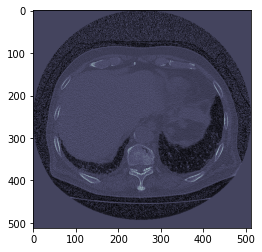

In [27]:
plt.imshow(pixel_array1, CMAP = 'bone')
plt.show()

c:\users\tom\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:2: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  


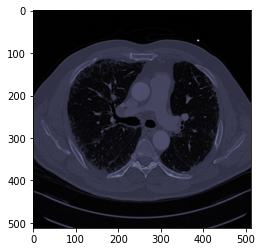

In [28]:
pixel_array2 = data2[0]
plt.imshow(pixel_array2, CMAP = 'bone')
plt.show()

In [ ]:
#looks kinda darker but its in HU scale

#### You can ignore the below code for now, it is scratch work, it will be useful later when we want to remove slices with bones and we want to trim the images, for now I am going to attempt to create a rough example of how we can use this data to train a simple nural network, in another notebook

In [113]:

#resize to our min and crop 25%
#https://www.pyimagesearch.com/2014/01/20/basic-image-manipulations-in-python-and-opencv-resizing-scaling-rotating-and-cropping/import cv2
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

crop = new_size*.20
start_y, end_y = int(crop), int(new_size-crop) #see hyperlink above
start_x, end_x = int(crop), int(new_size-crop)

for patient in tqdm(patients[:1]):
    path = data_dir + patient 
    slices = [pydicom.read_file(path + '/' + s) for s in os.listdir(path)] 
    slices.sort(key = lambda x: float(x.ImagePositionPatient[2]))
    slices = [cv2.resize(np.array(each_slice.pixel_array), (new_size, new_size)) for each_slice in slices]
    slices = [each_slice[start_y: end_y, start_x:end_x] for each_slice in slices] #see hyperlink above


        
    
    #plt.imshow(slices[350], cmap = "gray")
    #plt.show()


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15.38it/s]


In [169]:
import pandas as pd
df_slice_info = pd.DataFrame(columns = ['slice_num','slice_average',])
new_slice_array = []

for slice_num, each_slice in enumerate(slices):
    pixel_list = []
    for pixel in each_slice:
        pixel_sum = sum(pixel)
        pixel_list.append(pixel_sum)

    slice_average = sum(pixel_list)/(len(pixel_list))
    df_dict = {'slice_num' : int(slice_num), 'slice_average': slice_average }
    df_slice_info = df_slice_info.append(df_dict, ignore_index = True)
    df_slice_info = df_slice_info.astype(int) #convert to integer
    avg = df_slice_info.slice_average.mean()
    new_slices = df_slice_info[df_slice_info['slice_average']< avg]
    new_slice_list = new_slices.slice_num.tolist()
    
for good_slice in new_slice_list:
    new_slice_array.append(slices[good_slice])

In [173]:
#verify
print(new_slice_list)
new_slice_array[0] == slices[13]
new_slice_array[-1] == slices[29]

#it works

[13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]


array([[ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       ...,
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True]])

In [182]:
#put it all together


import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

much_data = []
errors = pd.DataFrame(columns = ['Patient', 'Error'])


crop = new_size*.20
start_y, end_y = int(crop), int(new_size-crop)
start_x, end_x = int(crop), int(new_size-crop)


for patient in patients:
    try:
        
        path = data_dir + patient 
        slices = [pydicom.read_file(path + '/' + s) for s in os.listdir(path)] 
        slices.sort(key = lambda x: float(x.ImagePositionPatient[2]))
        slices = [cv2.resize(np.array(each_slice.pixel_array), (new_size, new_size)) for each_slice in slices]
        slices = [each_slice[start_y: end_y, start_x:end_x] for each_slice in slices] #trim

        df_slice_info = pd.DataFrame(columns = ['slice_num','slice_average',])
        new_slice_array = []

        for slice_num, each_slice in enumerate(slices):
            pixel_list = []
            for pixel in each_slice:
                pixel_sum = sum(pixel)
                pixel_list.append(pixel_sum)

            slice_average = sum(pixel_list)/(len(pixel_list))
            df_dict = {'slice_num' : int(slice_num), 'slice_average': slice_average }
            df_slice_info = df_slice_info.append(df_dict, ignore_index = True)
            df_slice_info = df_slice_info.astype(int) #convert to integer
            avg = df_slice_info.slice_average.mean()
            new_slices = df_slice_info[df_slice_info['slice_average']< avg]
            new_slice_list = new_slices.slice_num.tolist()

        for good_slice in new_slice_list:
            new_slice_array.append(slices[good_slice])

        much_data.append([patient, new_slice_array])

        print(f'Patient: {patient} Initial: {len(slices)} New: {len(new_slice_array)}')
    except Exception as e:
        error_dict = {'Patient' : patient, 'Error': e}
        errors = errors.append(error_dict, ignore_index = True)
        


    
np.save('data.npy', much_data)
errors.to_csv('error_log.csv')

    


Patient: ID00007637202177411956430 Initial: 30 New: 17
Patient: ID00009637202177434476278 Initial: 394 New: 215
Patient: ID00010637202177584971671 Initial: 106 New: 65
Patient: ID00012637202177665765362 Initial: 49 New: 23
Patient: ID00014637202177757139317 Initial: 31 New: 21
Patient: ID00015637202177877247924 Initial: 295 New: 175
Patient: ID00019637202178323708467 Initial: 29 New: 18
Patient: ID00020637202178344345685 Initial: 493 New: 257
Patient: ID00023637202179104603099 Initial: 27 New: 11
Patient: ID00025637202179541264076 Initial: 24 New: 14
Patient: ID00027637202179689871102 Initial: 358 New: 226
Patient: ID00030637202181211009029 Initial: 433 New: 260
Patient: ID00032637202181710233084 Initial: 205 New: 115
Patient: ID00035637202182204917484 Initial: 574 New: 355
Patient: ID00038637202182690843176 Initial: 346 New: 204
Patient: ID00042637202184406822975 Initial: 497 New: 295
Patient: ID00047637202184938901501 Initial: 103 New: 55
Patient: ID00048637202185016727717 Initial: 2

Patient: ID00368637202296470751086 Initial: 341 New: 227
Patient: ID00370637202296737666151 Initial: 217 New: 132
Patient: ID00371637202296828615743 Initial: 364 New: 180
Patient: ID00376637202297677828573 Initial: 396 New: 212
Patient: ID00378637202298597306391 Initial: 346 New: 178
Patient: ID00381637202299644114027 Initial: 423 New: 234
Patient: ID00383637202300493233675 Initial: 32 New: 17
Patient: ID00388637202301028491611 Initial: 429 New: 267
Patient: ID00392637202302319160044 Initial: 56 New: 36
Patient: ID00393637202302431697467 Initial: 478 New: 280
Patient: ID00398637202303897337979 Initial: 49 New: 30
Patient: ID00400637202305055099402 Initial: 265 New: 139
Patient: ID00401637202305320178010 Initial: 24 New: 14
Patient: ID00405637202308359492977 Initial: 30 New: 19
Patient: ID00407637202308788732304 Initial: 54 New: 27
Patient: ID00408637202308839708961 Initial: 36 New: 23
Patient: ID00411637202309374271828 Initial: 278 New: 148
Patient: ID00414637202310318891556 Initial: 2

NameError: name 'error' is not defined